In [5]:
from mylib.statistic_test import *

code_id = '0030 - Decoding Results'
loc = os.path.join(figpath, code_id)
mkdir(loc)

        D:\Data\FinalResults\0030 - Decoding Results is already existed!


False

In [7]:
def naive_bayes_decode(trace):
    raw_trace = trace['RawTraces']
    Spikes = np.where(raw_trace - np.std(raw_trace, axis=1, keepdims=True)*3 >= 0, 1, 0)
    spike_nodes = trace['spike_nodes_original']
    ms_time = trace['ms_time']
    ms_time_behav = trace['ms_time_behav']
    
    idx = np.where(
        (np.isnan(spike_nodes) == False) & 
        np.isin(ms_time, ms_time_behav)
    )[0]
    Spikes = Spikes[:, idx]
    spike_nodes = spike_nodes[idx].astype(np.int64)
    
    proportions = int(spike_nodes.shape[0] / 5)+1
    boundaries = np.concatenate([np.arange(0, spike_nodes.shape[0], proportions).astype(np.int64), [spike_nodes.shape[0]]])
    
    loss = np.zeros(5)
    D = GetDMatrices(trace['maze_type'], 48)
    # Cross-validation
    for i in range(5):
        test_idx = np.arange(boundaries[i], boundaries[i+1])
        train_idx = np.setdiff1d(np.arange(spike_nodes.shape[0]), test_idx)
        
        train_spikes = Spikes[:, train_idx]
        test_spikes = Spikes[:, test_idx]
        train_nodes = spike_nodes[train_idx]
        test_nodes = spike_nodes[test_idx]
        
        # Train the model
        model = NaiveBayesDecoder(maze_type=trace['maze_type'], res=48, smooth_matrix=trace['Ms'])
        model.fit(train_spikes, train_nodes)
        # Predict
        pred_nodes = model.predict(test_spikes, test_nodes).astype(np.int64)
        # Calculate loss
        
        loss[i] = np.median(
            D[(pred_nodes-1, test_nodes-1)]
        )
    
    return np.mean(loss)

"""
for i in tqdm(range(len(f1))):
    if exists(f1['Trace File'][i]) == False:
        continue
    
    with open(join(f1['Trace File'][i]), 'rb') as handle:
        trace = pickle.load(handle)
    
    if 'gnb_decode_loss' in trace.keys():
        continue
    
    trace['gnb_decode_loss'] = naive_bayes_decode(trace)
    
    with open(join(f1['Trace File'][i]), 'wb') as handle:
        pickle.dump(trace, handle)
"""
pass

# Fig. S3G, S3H, S3J, S3K

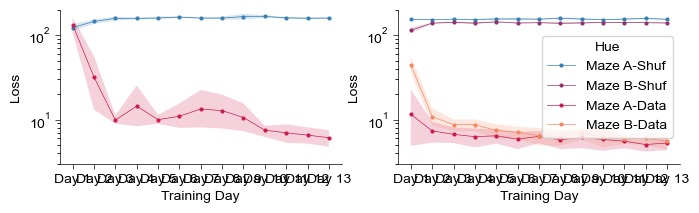

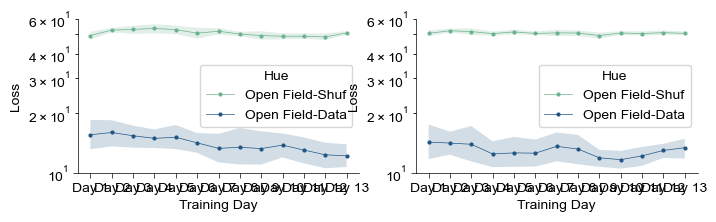

In [29]:
if exists(join(figdata, f'{code_id}.pkl')) == False:
    LossData = {
        "MiceID": [],
        "Training Day": [],
        "Stage": [],
        "Loss": [],
        "Type": [],
        "Maze Type": [],
    }
    
    mazes = ['Open Field', 'Maze A', 'Maze B']
    
    for i in tqdm(range(len(f1))):
        if exists(f1['Trace File'][i]) == False:
            continue
        
        with open(join(f1['Trace File'][i]), 'rb') as handle:
            trace = pickle.load(handle)
    
        loss = trace['gnb_decode_loss']
        
        raw_trace = trace['RawTraces']
        Spikes = np.where(raw_trace - np.std(raw_trace, axis=1, keepdims=True)*3 >= 0, 1, 0)
        spike_nodes = trace['spike_nodes_original']
        ms_time = trace['ms_time']
        ms_time_behav = trace['ms_time_behav']
        
        idx = np.where(
            (np.isnan(spike_nodes) == False) & 
            np.isin(ms_time, ms_time_behav)
        )[0]
        Spikes = Spikes[:, idx]
        spike_nodes = spike_nodes[idx].astype(np.int64)
        
        D = GetDMatrices(trace['maze_type'], 48)
        
        proportions = int(spike_nodes.shape[0] / 5)+1
        boundaries = np.concatenate([np.arange(0, spike_nodes.shape[0], proportions).astype(np.int64), [spike_nodes.shape[0]]])
        
        loss_shuf = np.zeros(5)
        for j in range(5):
            test_idx = np.arange(boundaries[j], boundaries[j+1])
            test_nodes = spike_nodes[test_idx]
            rand_idx = np.random.permutation(test_nodes.shape[0])
            loss_shuf[j] = np.median(
                D[(test_nodes[rand_idx]-1, test_nodes-1)]
            )
            
        loss_shuf = np.mean(loss_shuf)
        
        LossData['MiceID'].append([trace['MiceID'], trace['MiceID']])
        LossData['Training Day'].append([f1['training_day'][i], f1['training_day'][i]])
        LossData['Stage'].append([f1['Stage'][i], f1['Stage'][i]])
        LossData['Loss'].append([loss, loss_shuf])
        LossData['Type'].append(['Data', 'Shuf'])
        LossData['Maze Type'].append([mazes[trace['maze_type']], mazes[trace['maze_type']]])
    
    for k in LossData.keys():
        LossData[k] = np.concatenate(LossData[k])
        
    with open(join(figdata, f'{code_id}.pkl'), 'wb') as handle:
        pickle.dump(LossData, handle)
        
    LossD = pd.DataFrame(LossData)
    LossD.to_excel(join(figdata, f'{code_id}.xlsx'), index=False)
    print(len(LossD))
else:
    with open(join(figdata, f'{code_id}.pkl'), 'rb') as handle:
        LossData = pickle.load(handle)

LossData['Hue'] = np.array([f"{LossData['Maze Type'][i]}-{LossData['Type'][i]}" for i in range(len(LossData['Type']))])

MazeData = SubDict(LossData, LossData.keys(), np.where(np.isin(LossData['Maze Type'], ['Maze A', 'Maze B']))[0])
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 2))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
MazeStage1Data = SubDict(MazeData, MazeData.keys(), np.where(MazeData['Stage'] == 'Stage 1')[0])
MazeStage2Data = SubDict(MazeData, MazeData.keys(), np.where(MazeData['Stage'] == 'Stage 2')[0])

sns.lineplot(
    x='Training Day', 
    y='Loss', 
    hue='Hue', 
    data=MazeStage1Data, 
    ax=ax0, 
    palette=['#3680b3', '#92346b']+MazePalette[1:],
    hue_order=['Maze A-Shuf', 'Maze B-Shuf', 'Maze A-Data', 'Maze B-Data'],
    linewidth=0.5,
    #err_style='bars',
    #err_kws={'capsize': 3, 'elinewidth': 0.5, 'capthick': 0.5},
    err_kws={'edgecolor': None},
    legend=False,
    marker='o',
    markersize=3,
    markeredgewidth=0
)
sns.lineplot(
    x='Training Day', 
    y='Loss', 
    hue='Hue', 
    data=MazeStage2Data, 
    ax=ax1, 
    palette=['#3680b3', '#92346b']+MazePalette[1:],
    hue_order=['Maze A-Shuf', 'Maze B-Shuf', 'Maze A-Data', 'Maze B-Data'],
    linewidth=0.5,
    #err_style='bars',
    #err_kws={'capsize': 3, 'elinewidth': 0.5, 'capthick': 0.5},
    err_kws={'edgecolor': None},
    marker='o',
    markersize=3,
    markeredgewidth=0
)
ax0.semilogy()
ax1.semilogy()
ax0.set_ylim(3, 200)
ax1.set_ylim(3, 200)
plt.savefig(join(loc, "Maze Decoding Loss.png"), dpi=600)
plt.savefig(join(loc, "Maze Decoding Loss.svg"), dpi=600)
plt.show()

OpenFieldData = SubDict(LossData, LossData.keys(), np.where(LossData['Maze Type'] == 'Open Field')[0])
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 2))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
OpenFieldStage1Data = SubDict(OpenFieldData, OpenFieldData.keys(), np.where(OpenFieldData['Stage'] == 'Stage 1')[0])
OpenFieldStage2Data = SubDict(OpenFieldData, OpenFieldData.keys(), np.where(OpenFieldData['Stage'] == 'Stage 2')[0])

colors = sns.color_palette('crest', 4)
colors = [colors[0], colors[-1]]
sns.lineplot(
    x='Training Day', 
    y='Loss', 
    hue='Hue', 
    data=OpenFieldStage1Data, 
    ax=ax0, 
    palette=colors,
    hue_order=['Open Field-Shuf', 'Open Field-Data'],
    linewidth=0.5,
    #err_style='bars',
    #err_kws={'capsize': 3, 'elinewidth': 0.5, 'capthick': 0.5},
    err_kws={'edgecolor': None},
    marker='o',
    markersize=3,
    markeredgewidth=0
)
sns.lineplot(
    x='Training Day', 
    y='Loss', 
    hue='Hue', 
    data=OpenFieldStage2Data, 
    ax=ax1, 
    palette=colors,
    hue_order=['Open Field-Shuf', 'Open Field-Data'],
    linewidth=0.5,
    #err_style='bars',
    #err_kws={'capsize': 3, 'elinewidth': 0.5, 'capthick': 0.5},
    err_kws={'edgecolor': None},
    marker='o',
    markersize=3,
    markeredgewidth=0
)
ax0.semilogy()
ax1.semilogy()
ax0.set_ylim(10, 60)
ax1.set_ylim(10, 60)
plt.savefig(join(loc, "Open Field Decoding Loss.png"), dpi=600)
plt.savefig(join(loc, "Open Field Decoding Loss.svg"), dpi=600)
plt.show()

# Statistic Fig. S3I

Open Field: TtestResult(statistic=1.3791988942104356, pvalue=0.22633290703016062, df=5)
Maze A: TtestResult(statistic=8.491949458203246, pvalue=0.00037223151513596746, df=5)
Maze B: TtestResult(statistic=6.5017180137085075, pvalue=0.001285108602984001, df=5)


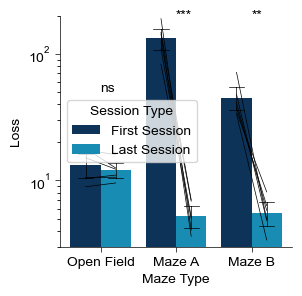

In [36]:
if exists(join(figdata, f'{code_id} [Statistics].pkl')) == False:
    LossStat = {
        "MiceID": [],
        "Session Type": [],
        "Loss": [],
        "Maze Type": [],
    }
    
    for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
        for i, maze_type in enumerate(['Open Field', 'Maze A', 'Maze B']):
            if i in [0, 1]:
                idx_first = np.where(
                    (LossData['MiceID'] == mouse) & 
                    (LossData['Stage'] == 'Stage 1') & 
                    (LossData['Maze Type'] == maze_type) &
                    (LossData['Type'] == 'Data') &
                    (LossData['Training Day'] == 'Day 1')
                )[0]
            else:
                idx_first = np.where(
                    (LossData['MiceID'] == mouse) & 
                    (LossData['Stage'] == 'Stage 2') & 
                    (LossData['Maze Type'] == maze_type) &
                    (LossData['Type'] == 'Data') &
                    (LossData['Training Day'] == 'Day 1')
                )[0]
                
            idx_last = np.where(
                (LossData['MiceID'] == mouse) & 
                (LossData['Stage'] == 'Stage 2') & 
                (LossData['Maze Type'] == maze_type) &
                (LossData['Type'] == 'Data') &
                (LossData['Training Day'] == 'Day 13')
            )[0]
                
            LossStat['MiceID'].append([mouse, mouse])
            LossStat['Session Type'].append(['First Session', 'Last Session'])
            LossStat['Loss'].append([LossData['Loss'][idx_first[0]], LossData['Loss'][idx_last[0]]])
            LossStat['Maze Type'].append([maze_type, maze_type])
            
    for k in LossStat.keys():
        LossStat[k] = np.concatenate(LossStat[k])
        
    with open(join(figdata, f'{code_id} [Statistics].pkl'), 'wb') as handle:
        pickle.dump(LossStat, handle)
        
    LossStatD = pd.DataFrame(LossStat)
    LossStatD.to_excel(join(figdata, f'{code_id} [Statistics].xlsx'), index=False)
    print(len(LossStatD))
else:
    with open(join(figdata, f'{code_id} [Statistics].pkl'), 'rb') as handle:
        LossStat = pickle.load(handle)
        
fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.barplot(
    x='Maze Type',
    y='Loss',
    hue='Session Type',
    data=LossStat,
    ax=ax,
    palette=['#003366', '#0099CC'],
    linewidth=0.5,
    err_kws={'color': 'k', 'linewidth': 0.5},
    capsize=0.4,
    width=0.8
)
for i, maze_type in enumerate(['Open Field', 'Maze A', 'Maze B']):
    idx0 = np.where(
        (LossStat['Maze Type'] == maze_type) & 
        (LossStat['Session Type'] == 'First Session')
    )[0]
    idx1 = np.where(
        (LossStat['Maze Type'] == maze_type) & 
        (LossStat['Session Type'] == 'Last Session')
    )[0]
    print(f"{maze_type}: {ttest_rel(LossStat['Loss'][idx0], LossStat['Loss'][idx1])}")
    for j in range(idx0.shape[0]):
        ax.plot(
            [i - 0.2, i + 0.2],
            [LossStat['Loss'][idx0[j]], LossStat['Loss'][idx1[j]]],
            color='k',
            linewidth=0.5
        )
ax.semilogy()
ax.set_ylim(3, 200)
ax.text(0, 50, 'ns')
ax.text(1, 190, '***')
ax.text(2, 190, '**')
plt.savefig(join(loc, "Maze Decoding Loss Statistic.png"), dpi=600)
plt.savefig(join(loc, "Maze Decoding Loss Statistic.svg"), dpi=600)
plt.show()